# Riccati solution reference

### Imports

In [1]:
import numpy as np
from pathlib import Path
import zipfile

from utils.export import *

from models.cart_pendulum import make_cart_pendulum
from models.vehicle_platoon import make_vehicle_platoon

from lqr.riccati import *

from utils.riccati_maps import *
from utils.trajectory import x_of_e_cart, x_of_e_vehicle, make_trajectory_result
from utils.plotting import plot_result

### Output saving settings

In [2]:
run_name = "riccati"  # used for filenames

ROOT = find_repo_root()
FIG_DIR, RES_DIR = ensure_out_dirs(ROOT)
print("Repo root:", ROOT)

run_id = make_run_id(run_name)
print("Run id:", run_id)

generated_files: list[Path] = []

Repo root: C:\Users\CristinaÁlvarezYuste\OneDrive - Quantum Mads\Documentos\GitHub\Quantum-assisted-Optimal-Control-examples
Run id: riccati_20260121_121100_126947


## 1) Cart Pendulum example

### Editable parameters

In [3]:
# --- Type of instance ---
MODEL_NAME = "cart_pendulum"     

# --- Time horizon and grid ---
T = 10.0
dt = 0.01

# --- Physical and model parameters ---
m = 1.0         # Pendulum mass 
M = 5.0         # Cart mass
L = 2.0         # Pendulum length
g = -10.0       # Gravity
delta = 1.0     # Friction coefficient

# --- Weights for the cost function ---
Q = np.eye(4)                         # State weight matrix
R = np.array([[1e-2]])                # Control weight matrix
H = np.diag([0.0, 10, 50.0, 10.0])    # Terminal state weight matrix

# --- Initial and reference states ---
x_ref = np.array([1.0, 0.0, np.pi, 0.0])         # Reference state
x0    = np.array([-1.0, 0.0, np.pi+0.1, 0.0])    # Initial state
                

# --- Output controls ---
save_plots = False
save_results = False
make_zip = False


### Create instance with those parameters

In [4]:
# Instance from LQRModel factory
model = make_cart_pendulum(T=T, dt=dt,m=m, M=M, L=L, g=g, delta=delta, Q=Q, R=R, H=H, x_ref=x_ref, x0=x0)

print("Created", model.name, "with dim =", model.A.shape[0])


Created cart_pendulum with dim = 4


## 1.1) Riccati ARE (Infinite horizon)

In [5]:
# --- Solution via Algebraic Riccati Equation (ARE) ---
ARE = lqr_gain_are(model.A, model.B, model.Q, model.R) # Stores P and K constant gains
print("ARE K shape:", ARE.K.shape)

# Simulate closed-loop system with constant gain K and initial error e0 (IVP)
t_ARE, E_ARE = simulate_constant_gain(
    model.A, model.B, ARE.K,
    e0=model.e0,
    t_eval=model.t_eval,
    method="Radau",
    rtol=1e-8,
    atol=1e-8,
)
assert np.allclose(t_ARE, model.t_eval)

# Riccati maps (Costate, control, state)
LAM_ARE = lam_of_e_are(E_ARE, ARE.P)
U_ARE   = u_of_e_are(E_ARE, ARE.K)
X_ARE = x_of_e_cart(E_ARE, model.x_ref)

# Trajectory result
tr_ARE = make_trajectory_result(
    method="ARE",
    model=model,
    t=t_ARE,
    E=E_ARE,
    LAM=LAM_ARE,
    X=X_ARE,
    U=U_ARE,
    meta={},
)

ARE K shape: (1, 4)


## 1.2) Riccati DRE (Finite horizon)

In [6]:
# --- Solution via Differential Riccati Equation (DRE) ---
DRE = lqr_gain_dre(
    model.A, model.B, model.Q, model.R,
    T=model.T,
    H_T=model.H,
    t_eval=model.t_eval,  
    method="Radau"
) # Stores P(t) and K(t) time-varying gains and forward time grid

print("DRE K shape:", DRE.K.shape)

# Simulate closed-loop system with time-varying gain K and initial error e0 (IVP)
t_DRE, E_DRE = simulate_timevarying_gain_piecewise(
    model.A, model.B, DRE.t, DRE.K,
    e0=model.e0,
    method="Radau",
    rtol=1e-8,
    atol=1e-8,
)
assert np.allclose(t_DRE, model.t_eval, DRE.t)

# Riccati maps (Costate, control, state)
LAM_DRE = lam_of_e_dre(E_DRE, DRE.P)
U_DRE   = u_of_e_dre(E_DRE, DRE.K)
X_DRE = x_of_e_cart(E_DRE, model.x_ref)

# Trajectory result
tr_DRE = make_trajectory_result(
    method="DRE",
    model=model,
    t=t_DRE,
    E=E_DRE,
    LAM=LAM_DRE,
    X=X_DRE,
    U=U_DRE,
    meta={},
)

DRE K shape: (1001, 1, 4)


## 1.3) Plots

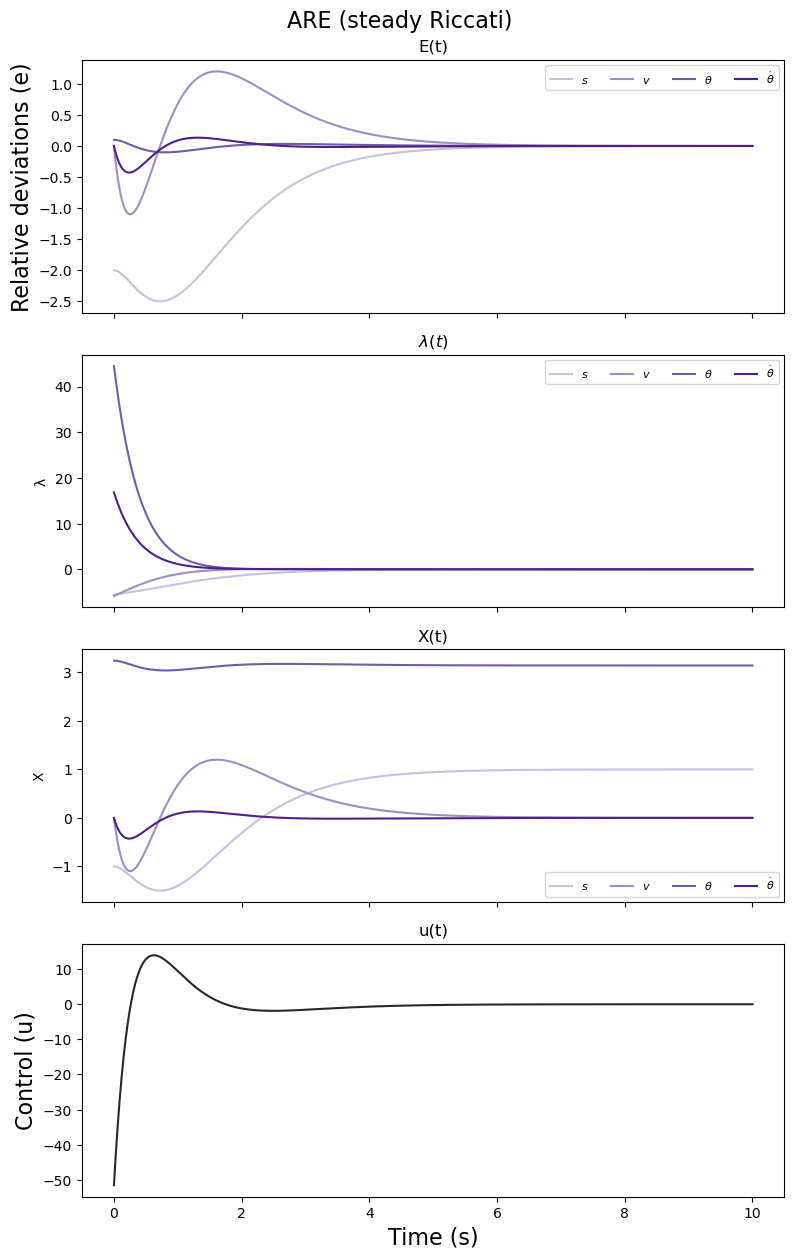

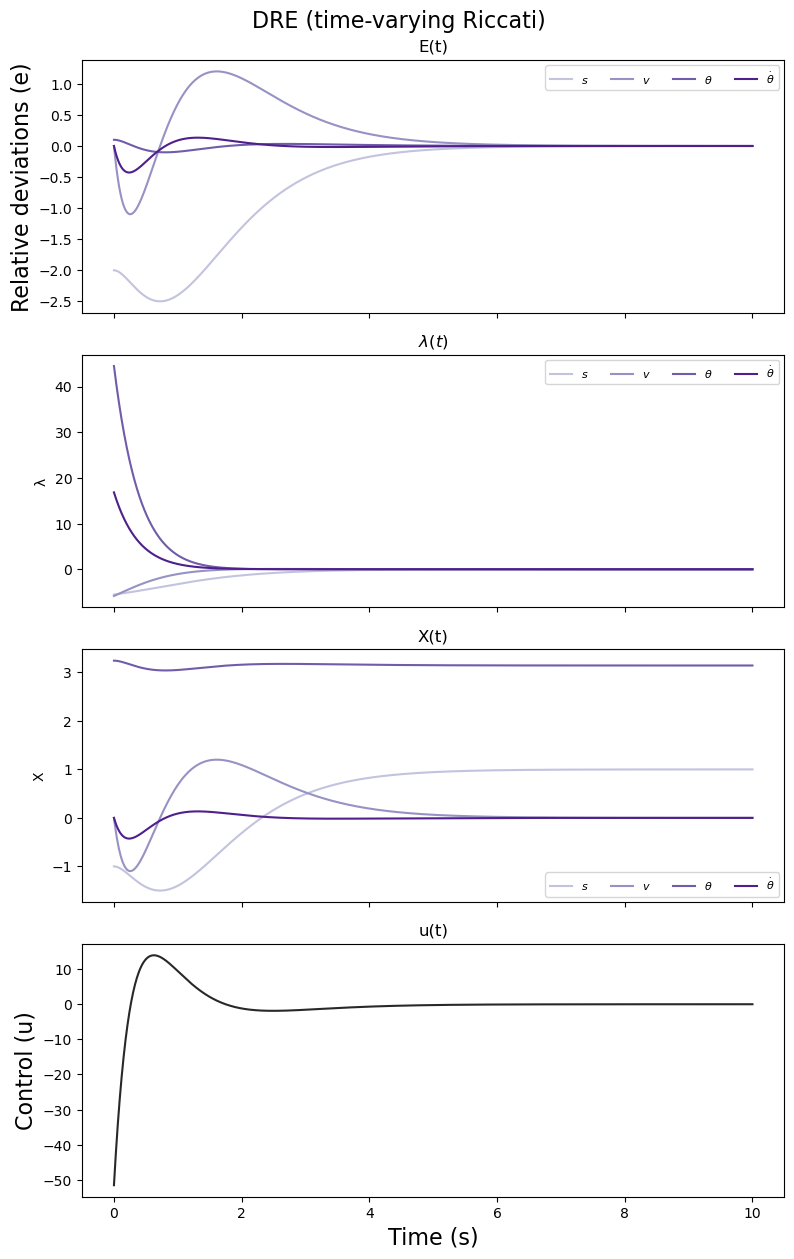

In [7]:
figARE, _axsARE = plot_result(
    tr_ARE,
    panels=("E", "LAM", "X", "U"),
    cart_labels=("s", "v", r"\theta", r"\dot{\theta}"),
    title="ARE (steady Riccati)",
    show=True,
)

figDRE, _axsDRE = plot_result(
    tr_DRE,
    panels=("E", "LAM", "X", "U"),
    cart_labels=("s", "v", r"\theta", r"\dot{\theta}"),
    title="DRE (time-varying Riccati)",
    show=True,
)

# --------- Save plots ----------
if save_plots:
    outARE = FIG_DIR / f"{run_id}_ARE_{tr_ARE.model_name}.pdf"
    outDRE = FIG_DIR / f"{run_id}_DRE_{tr_DRE.model_name}.pdf"
    figARE.savefig(outARE, dpi=200, bbox_inches="tight")
    figDRE.savefig(outDRE, dpi=200, bbox_inches="tight")
    generated_files += [outARE, outDRE]


# --------- Save results (JSON meta + NPZ arrays) ----------
if save_results:
    meta = {
        "run_id": run_id,
        "model_name": tr_ARE.model_name,
        "ARE": {"meta": dict(tr_ARE.meta)},
        "DRE": {"meta": dict(tr_DRE.meta)},
    }

    meta_path = RES_DIR / f"{run_id}_meta.json"
    save_json(meta_path, meta)
    generated_files.append(meta_path)

    npzM = RES_DIR / f"{run_id}_ARE_traj.npz"
    save_npz(npzM, t=tr_ARE.t, E=tr_ARE.E, LAM=tr_ARE.LAM, X=tr_ARE.X, U=tr_ARE.U)
    generated_files.append(npzM)

    npzV = RES_DIR / f"{run_id}_DRE_traj.npz"
    save_npz(npzV, t=tr_DRE.t, E=tr_DRE.E, LAM=tr_DRE.LAM, X=tr_DRE.X, U=tr_DRE.U)
    generated_files.append(npzV)




## 1.4) Save outputs into a single zip file

In [8]:
zip_path = RES_DIR / f"{run_id}_outputs.zip"

if make_zip:
    with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as zf:
        for p in generated_files:
            zf.write(p, arcname=str(p.relative_to(ROOT)))
    print("Created:", zip_path)
    try:
        from IPython.display import FileLink, display
        display(FileLink(str(zip_path)))
    except Exception:
        pass
else:
    print("make_zip=False; skipping zip creation")

print("\nGenerated files:")
for p in generated_files:
    print(" -", p)

make_zip=False; skipping zip creation

Generated files:


---

---

## 2) Vehicle platooning example

### Editable parameters

In [9]:
# --- Type of instance ---
MODEL_NAME = "vehicle_platoon"     

# --- Time horizon and grid ---
T = 10.0
dt = 0.001

# --- Physical and model parameters ---
n   = 6            # number of followers
d   = 5.0          # desired spacing [m]
d0  = 60.0         # initial spacing [m]
tau = 0.5          # actuator lag [s]

# ----------------- Single vehicle model ----------------
A0 = np.array([[0.0, 1.0,      0.0],
               [0.0, 0.0,      1.0],
               [0.0, 0.0, -1.0/tau]], dtype=float)  # (3x3)

b0 = np.array([[0.0],
               [0.0],
               [1.0/tau]], dtype=float)             # (3x1)

# LQR weights (per-vehicle)
Q0 = np.diag([1.0, 1.0, 1.0])   # on [spacing error, rel speed, rel accel]
R0 = np.array([[0.5]])          # scalar input weight (control effort)
# Terminal weight (stacked n-followers)
H = np.eye(3*n)

# ----------------- Stacked n-followers model --------------
# initial absolute states (leader + n followers)  length = n+1
s0 = 300.0
v0 = 7.0

s_abs = s0 - np.arange(0, n+1) * d0      # [s0, s0-d0, s0-2d0, ...]
v_abs = np.full(n+1, v0)
a_abs = np.zeros(n+1)

# ----------------- Leader dynamics (exogenous) ------------------
def u0(t): 
    u0 = 200* np.sin(2*t)                  # leader input can be time dependent!
    return u0               

           

# --- Output controls ---
save_plots = True
save_results = False
make_zip = False


### Create instance with those parameters

In [10]:
# Instance from LQRModel factory
model = make_vehicle_platoon(n=n, d=d, tau=tau, T=T, dt=dt, s_abs=s_abs, v_abs=v_abs, a_abs=a_abs, Q0=Q0, R0=R0, H=H, u0=u0, integrate_leader=True)

print("Created", model.name, "with dim =", model.A.shape[0])

Created vehicle_platoon with dim = 18


## 2.1) Riccati ARE (Infinite horizon)

In [11]:
# --- Solution via Algebraic Riccati Equation (ARE) ---
ARE = lqr_gain_are(model.A, model.B, model.Q, model.R) # Stores P and K constant gains
print("ARE K shape:", ARE.K.shape)

# Simulate closed-loop system with constant gain K and initial error e0 (IVP)
t_ARE, E_ARE = simulate_constant_gain(
    model.A, model.B, ARE.K,
    e0=model.e0,
    t_eval=model.t_eval,
    method="Radau",
    rtol=1e-8,
    atol=1e-8,
)
assert np.allclose(t_ARE, model.t_eval)

# Riccati maps (Costate, control, state)
LAM_ARE = lam_of_e_are(E_ARE, ARE.P)
U_ARE   = u_of_e_are(E_ARE, ARE.K)
X0 = model.leader_at(t_ARE) 
X_ARE = x_of_e_vehicle(E_ARE, X0, model.params["d"], n_followers=model.params["n"])

# Trajectory result
tr_ARE = make_trajectory_result(
    method="ARE",
    model=model,
    t=t_ARE,
    E=E_ARE,
    LAM=LAM_ARE,
    X=X_ARE,
    U=U_ARE,
    meta={},
)

ARE K shape: (6, 18)


## 2.2) Riccati DRE (Finite horizon)

In [12]:
# --- Solution via Differential Riccati Equation (DRE) ---
DRE = lqr_gain_dre(
    model.A, model.B, model.Q, model.R,
    T=model.T,
    H_T=model.H,
    t_eval=model.t_eval,  
    method="Radau"
) # Stores P(t) and K(t) time-varying gains and forward time grid
print("DRE K shape:", DRE.K.shape)

# Simulate closed-loop system with time-varying gain K and initial error e0 (IVP)
t_DRE, E_DRE = simulate_timevarying_gain_piecewise(
    model.A, model.B, DRE.t, DRE.K,
    e0=model.e0,
    method="Radau",
    rtol=1e-8,
    atol=1e-8,
)
assert np.allclose(t_DRE, model.t_eval, DRE.t)

# Riccati maps (Costate, control, state)
LAM_DRE = lam_of_e_dre(E_DRE, DRE.P)
U_DRE   = u_of_e_dre(E_DRE, DRE.K)
X0 = model.leader_at(DRE.t)
X_DRE = x_of_e_vehicle(E_DRE, X0, model.params["d"], n_followers=model.params["n"])

# Trajectory result
tr_DRE = make_trajectory_result(
    method="DRE",
    model=model,
    t=t_DRE,
    E=E_DRE,
    LAM=LAM_DRE,
    X=X_DRE,
    U=U_DRE,
    meta={},
)

DRE K shape: (10001, 6, 18)


## 2.3) Plots

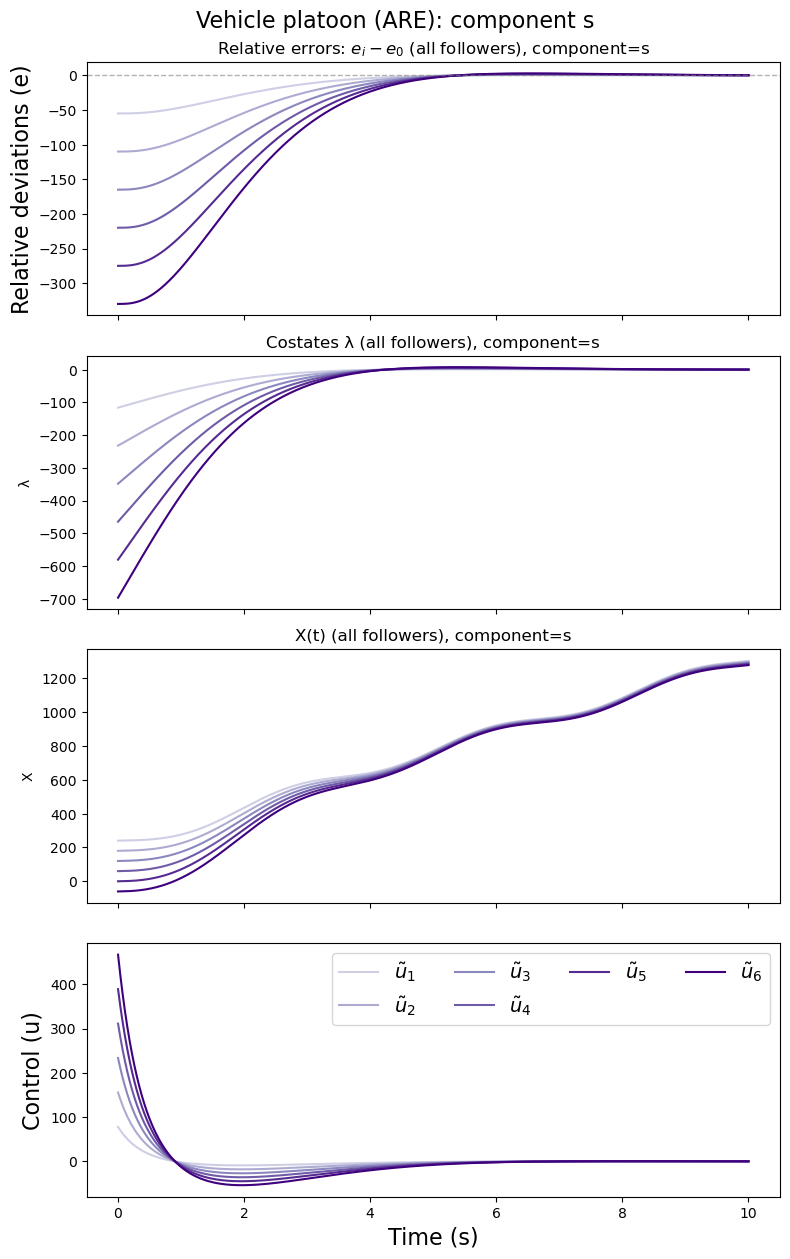

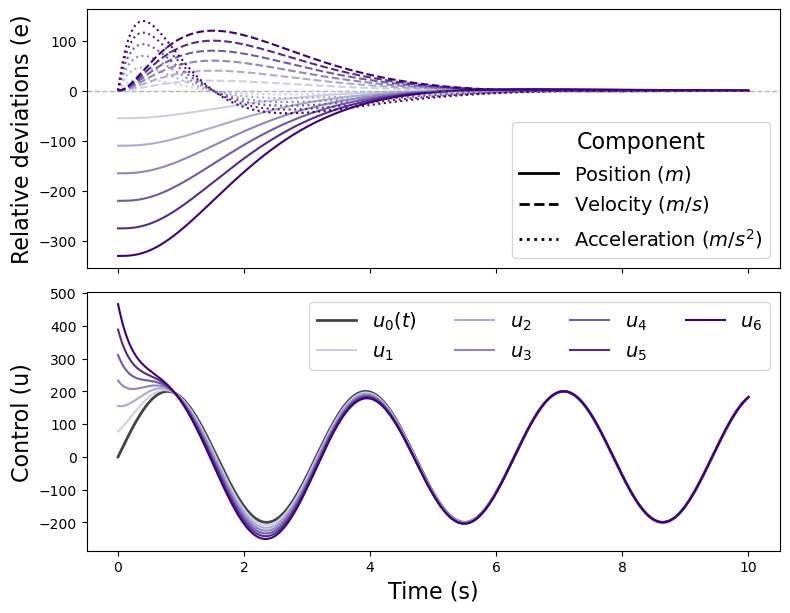

In [13]:
figARE, _axsARE = plot_result(
    tr_ARE,
    panels=("E", "LAM", "X", "U"),
    title="Vehicle platoon (ARE): component s",
    all_followers=True,          # todos los followers en el mismo panel
    vehicle_overlay_components=False,
    vehicle_component=0,         # 0=s, 1=v, 2=a
    vehicle_u_mode="tilde",      # ũ_i = u_i - u0
    include_u0=False,            
    show=True,
)

figDRE, _axsDRE = plot_result(
    tr_DRE,
    panels=("E","U"),
    vehicle_overlay_components=True,   # plot each vehicle's component in the same subplot
    all_followers=True,                # plot all followers' components

    include_u0=True,                   # add leader input to followers' inputs
    u0_fun=model.params["u0"],         

    vehicle_u_mode="absolute",         # u_i = u0 + ũ_i
                                       # vehicle_u_mode = "tilde"     
    show=True,                 
)


# --------- Save plots ----------
if save_plots:
    outARE = FIG_DIR / f"{run_id}_ARE_{tr_ARE.model_name}.pdf"
    outDRE = FIG_DIR / f"{run_id}_DRE_{tr_DRE.model_name}.pdf"
    figARE.savefig(outARE, dpi=200, bbox_inches="tight")
    figDRE.savefig(outDRE, dpi=200, bbox_inches="tight")
    generated_files += [outARE, outDRE]


# --------- Save results (JSON meta + NPZ arrays) ----------
if save_results:
    meta = {
        "run_id": run_id,
        "model_name": tr_ARE.model_name,
        "ARE": {"meta": dict(tr_ARE.meta)},
        "DRE": {"meta": dict(tr_DRE.meta)},
    }

    meta_path = RES_DIR / f"{run_id}_meta.json"
    save_json(meta_path, meta)
    generated_files.append(meta_path)

    npzM = RES_DIR / f"{run_id}_ARE_traj.npz"
    save_npz(npzM, t=tr_ARE.t, E=tr_ARE.E, LAM=tr_ARE.LAM, X=tr_ARE.X, U=tr_ARE.U)
    generated_files.append(npzM)

    npzV = RES_DIR / f"{run_id}_DRE_traj.npz"
    save_npz(npzV, t=tr_DRE.t, E=tr_DRE.E, LAM=tr_DRE.LAM, X=tr_DRE.X, U=tr_DRE.U)
    generated_files.append(npzV)




## 2.4) Save outputs into a single zip file

In [14]:
zip_path = RES_DIR / f"{run_id}_outputs.zip"

if make_zip:
    with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as zf:
        for p in generated_files:
            zf.write(p, arcname=str(p.relative_to(ROOT)))
    print("Created:", zip_path)
    try:
        from IPython.display import FileLink, display
        display(FileLink(str(zip_path)))
    except Exception:
        pass
else:
    print("make_zip=False; skipping zip creation")

print("\nGenerated files:")
for p in generated_files:
    print(" -", p)

make_zip=False; skipping zip creation

Generated files:
 - C:\Users\CristinaÁlvarezYuste\OneDrive - Quantum Mads\Documentos\GitHub\Quantum-assisted-Optimal-Control-examples\figures\riccati_20260121_121100_126947_ARE_vehicle_platoon.pdf
 - C:\Users\CristinaÁlvarezYuste\OneDrive - Quantum Mads\Documentos\GitHub\Quantum-assisted-Optimal-Control-examples\figures\riccati_20260121_121100_126947_DRE_vehicle_platoon.pdf
